# Snake – supervisory


Uses the shared `SnakeEnv` class and dynamics helpers.

In [1]:
import sys
from pathlib import Path

def _find_repo_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / 'clean').exists():
            return p
    return start

ROOT = _find_repo_root(Path(__file__).resolve()) if '__file__' in globals() else _find_repo_root(Path.cwd().resolve())
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from clean.lib.snake_env import SnakeEnv

os.environ.setdefault('MUJOCO_GL', 'egl')
FOLDER = 'snake_pattern_supervisory'
os.makedirs(FOLDER, exist_ok=True)


In [12]:
env = SnakeEnv(xml_path='snake_model_obstacle.xml')
env.initialize_neural_controller(mode="pattern")
env.edge_colours_by_id.append([set(), 'purple'])
env.edge_colours_by_id.append([set(), 'grey'])
env.edge_colours_by_id.append([set(), 'grey'])

for i in range(4):
    env.neuron_names[f"{i+10}"] = f"Left Joint{i+1}"
    env.node_pos_by_name[f"Left Joint{i+1}"] = [0, 0 + i * 200]
    env.neuron_names[f"{i+14}"] = f"Right Joint{i+1}"
    env.node_pos_by_name[f"Right Joint{i+1}"] = [1000, 0 + i * 200]
    env.neuron_names[f"{i}"] = f"Foward {i+1}"
    env.neuron_names[f"{i+6}"] = f"Backward {i+1}"
    env.edge_colours_by_id[0][0].add(i + 10)
    env.edge_colours_by_id[0][0].add(i + 14)
    env.edge_colours_by_id[1][0].add(i + 10)
    env.edge_colours_by_id[1][0].add(i + 28)
    env.edge_colours_by_id[1][0].add(i + 32)
    env.edge_colours_by_id[2][0].add(i + 14)
    env.edge_colours_by_id[2][0].add(i + 28)
    env.edge_colours_by_id[2][0].add(i + 32)

env.neuron_names["18"] = "Turn Right 1"
env.neuron_names["19"] = "Turn Right 2"
env.neuron_names["20"] = "Turn Left 1"
env.neuron_names["21"] = "Turn Left 2"
env.neuron_names["22"] = "Forward 1"
env.neuron_names["23"] = "Forward 2"
env.neuron_names["24"] = "Left first 1"
env.neuron_names["25"] = "Left first 2"
env.neuron_names["26"] = "Right first 1"
env.neuron_names["27"] = "Right first 2"

env.set_graph()
graphs_html = env.calculate_graph([True, False, False, False])
print(graphs_html)


Using default neural controller, because no neuron_types,syn_matrixs,shifts,syn_taus or syn_alphas is provided
[[-0.  -2.5 -2.5 ... -0.  -0.  -0. ]
 [-2.5 -0.  -2.5 ... -0.  -0.  -0. ]
 [-2.5 -2.5 -0.  ... -0.  -0.  -0. ]
 ...
 [-0.  -0.  -0.  ... -0.  -0.   1.5]
 [-0.  -0.  -0.  ... -0.  -0.  -0. ]
 [-0.  -0.  -0.  ... -0.  -0.  -0. ]]
[[0.   0.   0.   ... 0.   0.   0.  ]
 [0.75 0.   0.   ... 0.   0.   0.  ]
 [0.   0.75 0.   ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]]
{'full': PosixPath('four_relations_network.html'), 'community:38': PosixPath('community_38.html'), 'community:39': PosixPath('community_39.html'), 'community:40': PosixPath('community_40.html'), 'community:41': PosixPath('community_41.html'), 'community:42': PosixPath('community_42.html'), 'community:43': PosixPath('community_43.html'), 'residual': PosixPath('residual_edges.html')}


In [13]:
def u(t,neuron_states,joint_positions,joint_velocities,sensor):
    const_input=np.zeros(env.num_neuron)
    modulation=np.zeros(env.num_neuron)
    modulation[4:6]=0.2
    const_input[:]=-0.5

    const_input[10:18]=np.ones(8)*0
    const_input[28:36]=-2.0
    const_input[22:24]=-2.0
    const_input[36:38]=-2.0
    const_input[18:20]=-2.0
    const_input[0:10]+=1
    period=5
    modulation_motor=-1.25*np.ones((env.num_neuron))
    if 0<t<1:
        const_input[18]+=1.0
    if 1<t <2:
        const_input[0]=3
    if 2<t<3:
        const_input[26]=3

    if t>5 and sensor >1:
        const_input[18]+=1.0
        const_input[19]+=1.0
 
        
    return const_input, modulation,period,modulation_motor

folder = FOLDER
env.record_video(filename='snake_simulation.mp4', fps=30, out_dir=folder, u=u)
env.close()


Video saved to snake_pattern_supervisory/snake_simulation.mp4


In [14]:
volt_traces = np.array(env.neuron_outputs)[:, :, 0].T
env.build_dashboard(volt_traces, video_file='snake_simulation.mp4', out_dir=FOLDER, fps=30)


✔ Dashboard ready → snake_pattern_supervisory/all_animations.html


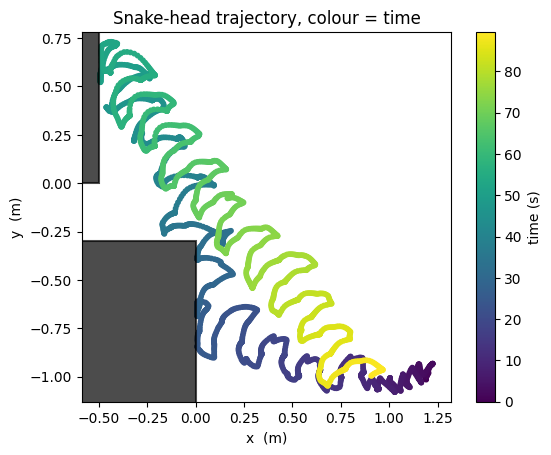

In [15]:
from matplotlib.patches import Rectangle

# square block: lower-left at (-0.5, -0.8), width=height=0.5
block = Rectangle(
    (-0.5-0.5, -0.8-0.5), 1, 1,
    facecolor='0.0', alpha=0.7,   # fill + slight transparency
    edgecolor='k', linewidth=1.5,
    zorder=3                      # draw above scatter
)

block2 = Rectangle(
    (-1-0.5, 0.5-0.5), 1, 1,
    facecolor='0.0', alpha=0.7,   # fill + slight transparency
    edgecolor='k', linewidth=1.5,
    zorder=3                      # draw above scatter
)

trajectory = np.array(env.head_xyz)[:,:2]
t = np.arange(len(trajectory))          # 0 … T-1
x, y = trajectory.T

fig, ax = plt.subplots()
sc = ax.scatter(x, y, c=t*1/30, cmap="viridis", s=10)   # one dot per step
dim  = max(x.ptp(), y.ptp())+0.1          # largest span
xmid = (x.max() + x.min())/2
ymid = (y.max() + y.min())/2
ax.set_xlim(xmid - dim/2, xmid + dim/2)
ax.set_ylim(ymid - dim/2, ymid + dim/2)
cbar = fig.colorbar(sc, label="time (s)", ax=ax)                # legend on the right

# from matplotlib.ticker import FuncFormatter
# # multiply every tick value (which is a step index) by dt
# cbar.ax.yaxis.set_major_formatter(
#         FuncFormatter(lambda v, pos: f"{v*1/30:.2f}"))
# cbar.update_ticks()
ax.add_patch(block)
ax.add_patch(block2)
ax.set_aspect("equal")
ax.set_xlabel("x  (m)")
ax.set_ylabel("y  (m)")
ax.set_title("Snake-head trajectory, colour = time")
fig.savefig(f'{FOLDER}/snake_head_trajectory.png')
plt.show()


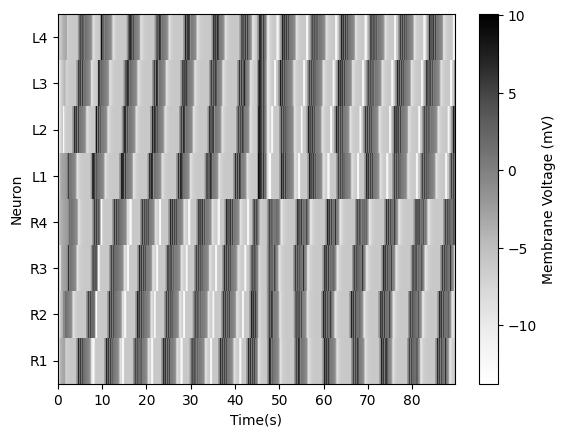

In [9]:
data = np.flip(np.array(env.neuron_outputs)[:, 10:18, 0], 1)
neuron_names = ['R1', 'R2', 'R3', 'R4', 'L1', 'L2', 'L3', 'L4']
plt.imshow(data.T, aspect='auto', interpolation='none', cmap='Greys', extent=[0, data.shape[0] * 1 / 30, 0, data.shape[1]])
plt.xlabel('Time(s)')
plt.ylabel('Neuron')
plt.colorbar(label='Membrane Voltage (mV)')
plt.yticks(ticks=np.arange(0.5, data.shape[1], 1), labels=neuron_names)
plt.savefig(f'{FOLDER}/raster_HCO.png')


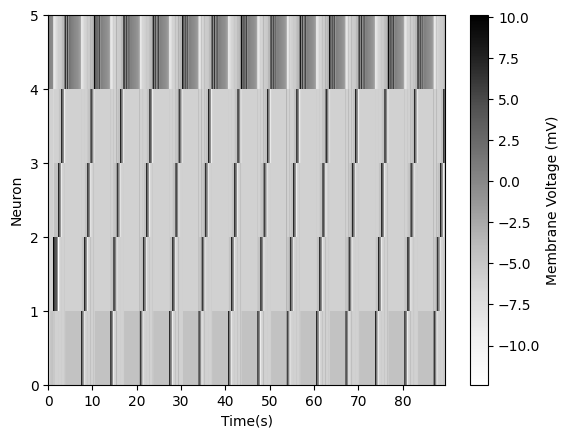

In [10]:
data= np.flip(np.array(env.neuron_outputs)[0:,0:5,0],1)
# Use imshow to create a raster plot, transposing so neurons appear on the y-axis.
plt.imshow(data.T, aspect='auto', interpolation='none', cmap='Greys',extent=[0, data.shape[0] * 1/30, 0, data.shape[1]])
plt.xlabel('Time(s)')
plt.ylabel('Neuron')
plt.colorbar(label='Membrane Voltage (mV)')
plt.savefig(f'{FOLDER}/raster_HCO.png')